In [239]:
import pysam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
from utils import *
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### Calculate the coverage by CRISPR-based targeted locus enrichment

In [3]:
CRISPR_bam_path = "/home/yanhu/data/DddA/enrich_benchmark/merged.sorted.bam"

chrom = "chr11"
sgRNA_pos = [5279083, 5279276, 5282342, 5282585]
plot_start = int(np.mean(sgRNA_pos)) - 10000
plot_end = int(np.mean(sgRNA_pos)) + 10000

In [4]:
# Open the BAM file
samfile = pysam.AlignmentFile(CRISPR_bam_path, "rb")

# Initialize an array to store coverage values
CRISPR_coverage = np.zeros(plot_end - plot_start)

# Iterate through all reads that overlap the region
for pileupcolumn in samfile.pileup(chrom, plot_start, plot_end, truncate=True):
    # Calculate the relative position within our region of interest
    pos = pileupcolumn.pos - plot_start
    CRISPR_coverage[pos] = pileupcolumn.n

samfile.close()

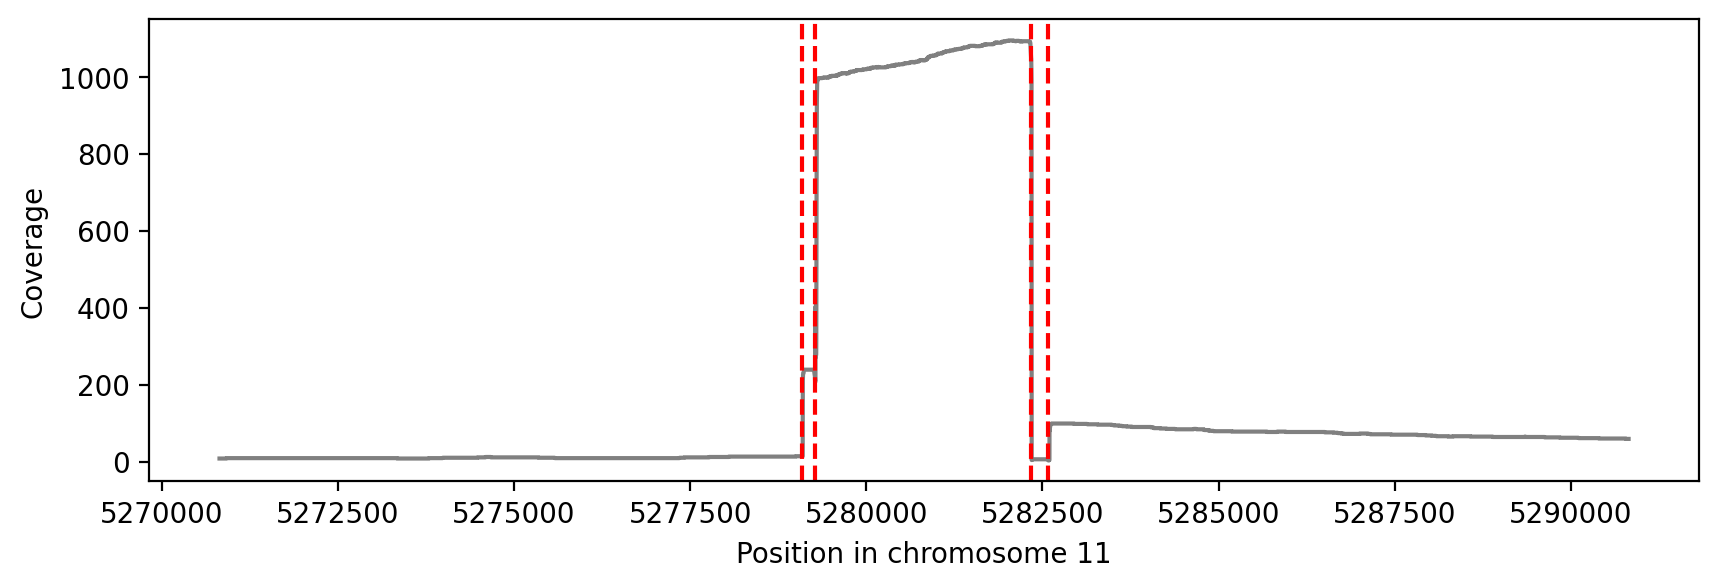

In [60]:
fig, ax = plt.subplots(dpi=200, figsize=(10,3))
ax.plot(np.arange(plot_start, plot_end), CRISPR_coverage, color="grey")
for pos in sgRNA_pos:
    ax.axvline(x=pos, linestyle="dashed", color="red")
plt.xlabel("Position in chromosome 11")
plt.ylabel("Coverage")

# Prevent showing scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("/home/yanhu/data/DddA/enrich_benchmark/plots/CRISPR_enrich_coverage.pdf")
plt.show()

In [49]:
coverage_dfastq_path = "/home/yanhu/data/DddA/enrich_benchmark/merged.fastq.gz"
with gzip.open(fastq_path, 'rt') as f:
    seq_depth = sum(1 for _ in f) / 4
coverage_dict = {"CRISPR_enrich" : np.max(CRISPR_coverage) / (seq_depth / 1e6)}ict["CRISPR_enrich"] = coverage_dict["CRISPR_enrich"] * 1e6

### Also align HJR250, HJR306 (TDAC-seq without any Cas9 cutting), and HJR312 data (Gfi1b pooled screen)

In [340]:
for sample in ["HJR250_8", "HJR306_6", "HJR312_1", "HJR312_2"]:

    dataset = re.split("_", sample)[0]

    # Create a dictionary for reference regions
    if dataset == "HJR312":
        ref_range_dict = {
            dataset : ('chr9', 133002683, 133005465)
        }      
    elif dataset == "HJR250":
        ref_range_dict = {
            dataset : ('chr11', 5279265, 5282582)
        }        
    elif dataset == "HJR306":
        ref_range_dict = {
            dataset : ('chr11', 5279265, 5282582)
        }        
        
    # If we have already aligned reads before, load the saved ddda_data object
    save_path = f"/home/yanhu/data/DddA/{dataset}/ddda_data_{sample}.pkl"
    if os.path.exists(save_path):
        continue
    print("Processing", sample)
        
    # Initialize ddda_dataset
    ddda_data = ddda_dataset(
        ID = sample, 
        region_dict = ref_range_dict, 
        genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
        fastq_file = f"/home/yanhu/data/DddA/{dataset}/fastqs/{sample}_merged.fastq.gz", 
        working_dir = f"/home/yanhu/data/DddA/{dataset}/"
    )
    
    # Load DddA bias model
    with open("/home/yanhu/data/DddA/HJR245/bias_dict.pkl", "rb") as f:
        ddda_data.bias_model = pickle.load(f)
    
    # Align reads
    gap_threshold = 500
    ddda_data.align_reads(
        start_gap_threshold = gap_threshold,
        end_gap_threshold = gap_threshold
    )
    
    with open(save_path, "wb") as f:
        pickle.dump(ddda_data, f)

Processing HJR312_1
Loading reference genome
Extracting sequences for each locus
Computing sequence bias


11515308it [1:00:27, 3174.11it/s]


7855025 reads aligned. 3660283 reads unaligned
Processing HJR312_2
Loading reference genome
Extracting sequences for each locus
Computing sequence bias


10023902it [43:53, 3806.22it/s]


6734508 reads aligned. 3289394 reads unaligned


### Now compare the coverage of different datasets

In [341]:
fastq_dict = {
    "HJR244_1":"/home/yanhu/data/DddA/HJR244/fastqs/HJR244_1/merged.fastq.gz",
    "HJR244_2":"/home/yanhu/data/DddA/HJR244/fastqs/HJR244_2/merged.fastq.gz",
    "HJR244_3":"/home/yanhu/data/DddA/HJR244/fastqs/HJR244_3/HJR244_3_merged.fastq.gz",
    "HJR244_4":"/home/yanhu/data/DddA/HJR244/fastqs/HJR244_4/HJR244_4_merged.fastq.gz",
    "HJR250_8":"/home/yanhu/data/DddA/HJR250/fastqs/HJR250_8_merged.fastq.gz",
    "HJR306_6":"/home/yanhu/data/DddA/HJR306/fastqs/HJR306_6_merged.fastq.gz",
    "HJR312_1":"/home/yanhu/data/DddA/HJR312/fastqs/HJR312_1_merged.fastq.gz",
    "HJR312_2":"/home/yanhu/data/DddA/HJR312/fastqs/HJR312_2_merged.fastq.gz",
}

In [342]:
samples = list(fastq_dict.keys())
loci = [re.split("_", sample)[0] for sample in samples]
for sample_ind in range(len(samples)):

    sample = samples[sample_ind]
    locus = loci[sample_ind]

    # Load previously initialized ddda_dataset objects
    ddda_data_path = "/home/yanhu/data/DddA/" + locus + "/ddda_data_" + sample + ".pkl"
    with open(ddda_data_path, "rb") as f:
        ddda_data = pickle.load(f)

    # Calculate coverage
    TDAC_coverage = ddda_data.edit_dict[locus].shape[0]
    print(TDAC_coverage)

    # Run deduplication on randomly sampled reads to estimate duplication rate
    sample_read_inds = np.random.choice(np.arange(TDAC_coverage), 10000)
    dedup_read_inds = ddda_data.dedup_reads(
        locus = locus, 
        read_ids = np.array(ddda_data.read_ids[locus])[sample_read_inds]
    )
    adjusted_coverage = TDAC_coverage * len(dedup_read_inds) / len(sample_read_inds)

    # Further adjust by sequencing depth to get coverage per 1 million reads
    fastq_path = fastq_dict[sample]
    with gzip.open(fastq_path, 'rt') as f:
        seq_depth = sum(1 for _ in f) / 4
    adjusted_coverage = adjusted_coverage / (seq_depth / 1e6)
    coverage_dict[sample] = adjusted_coverage

1124263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8009.69it/s]
10000it [00:00, 1051098.64it/s]


2039554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7996.19it/s]
10000it [00:00, 1018727.29it/s]


2099568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8016.61it/s]
10000it [00:00, 745654.04it/s]


2308993


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8096.32it/s]
10000it [00:00, 663120.58it/s]


98176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8053.10it/s]
10000it [00:00, 1013900.60it/s]


100854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8154.45it/s]
10000it [00:00, 1017886.72it/s]


7855025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7802.59it/s]
10000it [00:00, 984971.47it/s]


6734508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7791.68it/s]
10000it [00:00, 1039454.78it/s]


### Visualize results

In [348]:
coverage_dict

{'CRISPR_enrich': 957.1987905203227,
 'HJR244_1': 578451.0117032337,
 'HJR244_2': 577578.2728421697,
 'HJR244_3': 623184.064767162,
 'HJR244_4': 604181.8471827771,
 'HJR250_8': 178745.68672280153,
 'HJR306_6': 410547.3661106233,
 'HJR312_1': 652669.2920415156,
 'HJR312_2': 653705.1423687104}

In [349]:
rename_dict = {
    "CRISPR_enrich" : "Cas9 enrich",
    "HJR250_8" : "WT rep 1",
    "HJR306_6" : "WT rep 2",
    'HJR244_1' : "HS2 Cas9\npool rep1",
    'HJR244_2' : "HS2 Cas9\npool rep2",
    'HJR244_3' : "HS2 ABE\npool rep1",
    'HJR244_4' : "HS2 ABE\npool rep2",
    'HJR312_1' : "Gfi1b Cas9\npool rep1",
    'HJR312_2' : "Gfi1b Cas9\npool rep2"
}

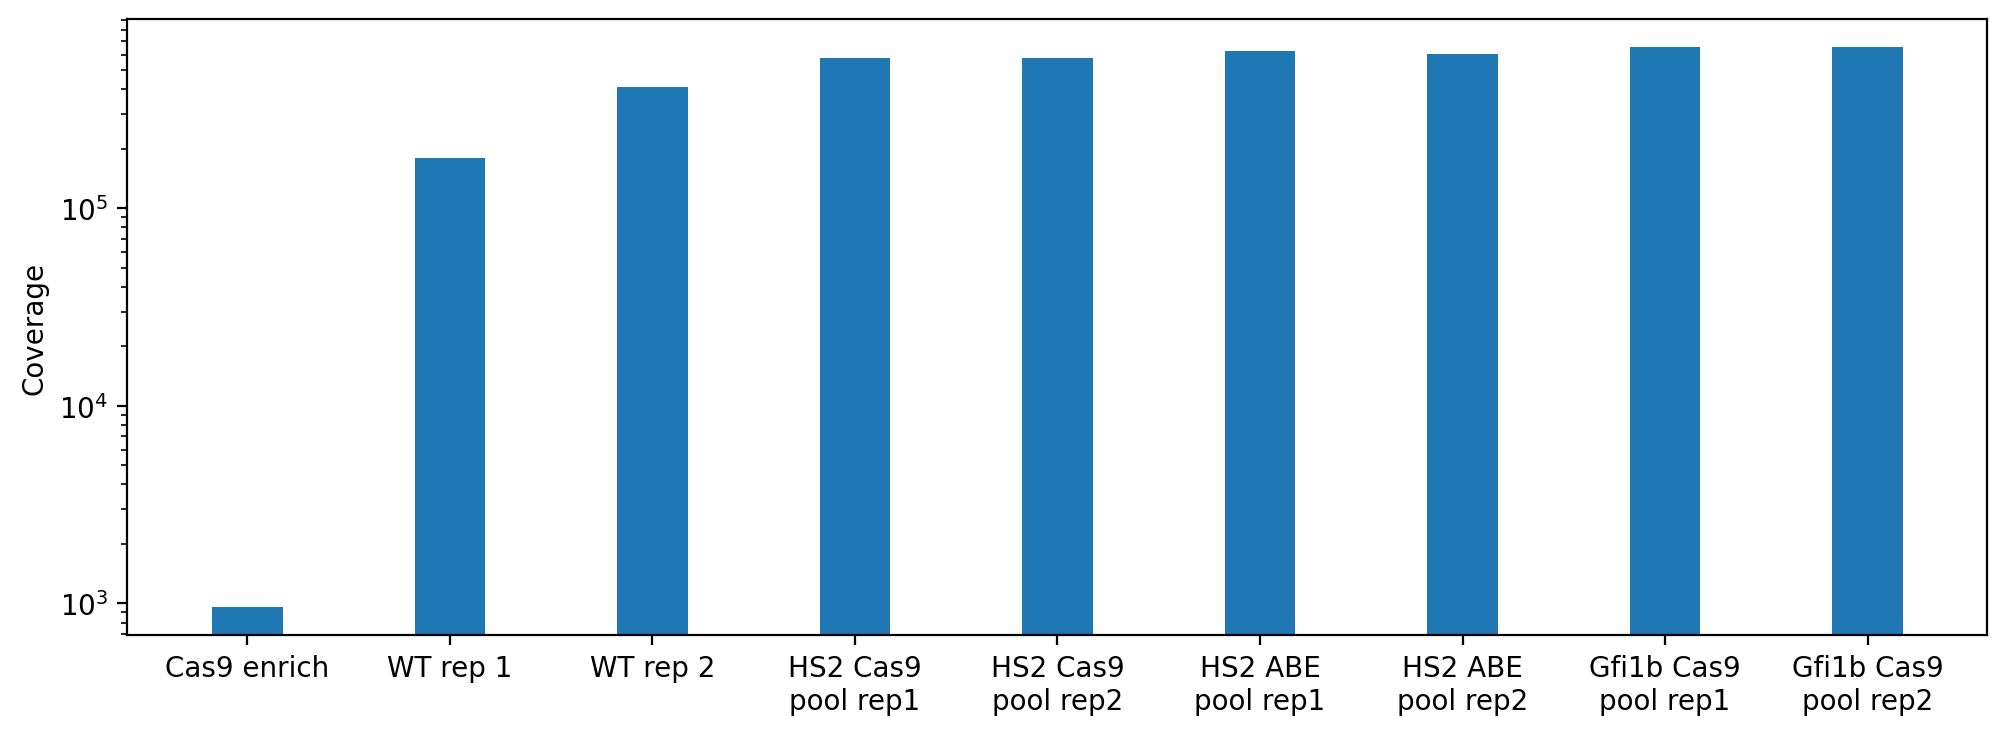

In [351]:
fig, ax = plt.subplots(dpi=200, figsize=(12, 4))
x = np.arange(len(coverage_dict.keys()))
width = 0.35
rename_samples = list(rename_dict.keys())
bars = ax.bar(x - width/2, [coverage_dict[i] for i in rename_samples], width)
ax.set_xticks(x - width/2)
ax.set_xticklabels([rename_dict[i] for i in rename_samples])
plt.yscale('log', base=10) 
plt.ylabel("Coverage")
plt.savefig("/home/yanhu/data/DddA/enrich_benchmark/plots/benchmark_barplot.pdf")